#  Задание
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [1]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn import svm

In [2]:
data = pd.read_csv('./data/digit/train.csv')
x = data.drop(['label'], axis = 1)
y = data['label']

In [3]:
train, test, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)

print("Train Data Shape: ",train.shape)
print("Train Label Shape: ",train_labels.shape)
print("Test Data Shape: ",test.shape)
print("Test Label Shape: ",test_labels.shape)

Train Data Shape:  (33600, 784)
Train Label Shape:  (33600,)
Test Data Shape:  (8400, 784)
Test Label Shape:  (8400,)


In [4]:
%%time
#Я использую RandomForestClassifier, после того, как SVM у меня считал очень долго - более 7 минут
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500, max_depth = 2 , n_jobs = -1, random_state = 42)
rfc.fit(train, train_labels.values.ravel())

Wall time: 3.26 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [5]:
pred_labels = rfc.predict(test)

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_labels, pred_labels)

0.6466666666666666

В принципе, accuracy уже больше 0,6 и лможно было бы закончить :), но задание тогда было бы выполненно не полным.
Я решил взяьт PCA для повышения точности классификатора. Если бы я взял HOG, то действовал бы так же. 

In [7]:
confusion_matrix(test_labels, pred_labels)

array([[798,   0,   1,   2,   0,   0,   5,   9,   1,   0],
       [  1, 901,   2,   0,   0,   0,   1,   3,   0,   1],
       [ 63, 207, 496,  13,  12,   0,  16,  33,   6,   0],
       [ 70, 176,  21, 578,   8,   2,   3,  36,  10,  33],
       [ 10,  12,   9,   2, 555,   0,  30,  63,   4, 154],
       [155, 105,   6, 210,  40,  61,  27,  34,  18,  46],
       [112,  77,  32,   8,  28,   0, 494,  28,   1,   5],
       [ 25,  67,  20,   0,   9,   0,   0, 748,   3,  21],
       [ 16, 262,  40,  49,  24,   0,  21,   9, 360,  54],
       [ 15,  27,   5,  15, 175,   0,   7, 149,   4, 441]], dtype=int64)

Text(0, 0.5, 'Variance')

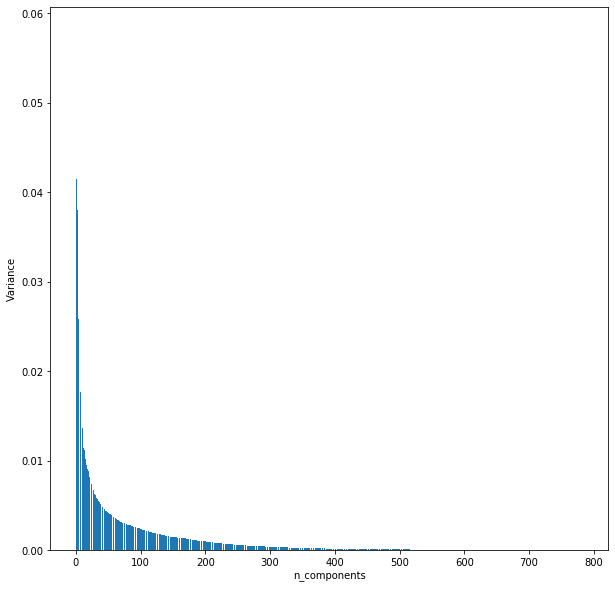

In [8]:
#нормализую датасет для PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

sc = StandardScaler().fit(train)
X_std_train = sc.transform(train)
X_std_test = sc.transform(test)

#я использую следующий код для определния n_components для PCA - вязл с kaggle :)
sklearn_pca = sklearnPCA().fit(X_std_train)
train_pca = sklearn_pca.transform(X_std_train)
test_pca = sklearn_pca.transform(X_std_test)

var_per = sklearn_pca.explained_variance_ratio_
cum_var_per = sklearn_pca.explained_variance_ratio_.cumsum()

#визуализация
plt.figure(figsize=(10,10))
ind = np.arange(len(var_per)) 
plt.bar(ind,var_per)
plt.xlabel('n_components')
plt.ylabel('Variance')

In [9]:
#опредеялю количество n_components, при которых сохраняется 90% информации
n_comp = len(cum_var_per[cum_var_per <= 0.90])
print("90% информации сохраняются при n_components=", n_comp, '\n')
sklearn_pca = sklearnPCA(n_components = n_comp)
train_pca = sklearn_pca.fit_transform(X_std_train)
test_pca = sklearn_pca.transform(X_std_test)

print("Размер train перед PCA:", X_std_train.shape, '\n')
print("Размер train после PCA:", train_pca.shape, '\n')
print("Размер test перед PCA:", X_std_test.shape)
print("Размер test после PCA:", test_pca.shape, '\n')

90% информации сохраняются при n_components= 222 

Размер train перед PCA: (33600, 784) 

Размер train после PCA: (33600, 222) 

Размер test перед PCA: (8400, 784)
Размер test после PCA: (8400, 222) 



In [10]:
%%time
rfc.fit(train_pca, train_labels.values.ravel())
score = rfc.score(test_pca,test_labels)
print(score)

0.7477380952380952
Wall time: 13.3 s


### Точность > 0.7